In [1]:
import numpy as np
from torcheeg.datasets import NumpyDataset, MNEDataset
from torcheeg import transforms
from torcheeg.transforms.pyg import ToG
from matplotlib import pyplot as plt
from utils_hugo import read_subject_epochs

In [2]:
bids_dir = "/Users/hugofluhr/DATA/ds003505/"
epochs, y = read_subject_epochs(bids_dir=bids_dir, subject='sub-01', tmin=0)
metadata_list = [{'event': i} for i in y]

Applying baseline correction (mode: mean)


/Users/hugofluhr/Documents/Cours/NML/NetworkMachineLearning_2023/notebooks_hugo/utils_hugo.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


In [3]:
epochs.get_data().shape

(588, 128, 126)

In [4]:
X = epochs.get_data()[0,:,:]

In [5]:
X.shape

(128, 126)

In [6]:
len(X)

128

In [7]:
def pearson_corr_coef(x,y, abs=True):
    corr_coef = np.corrcoef(x,y)[0][1]
    if abs:
        return np.abs(corr_coef)
    else :
        return corr_coef

In [8]:
from scipy.signal import hilbert

def plv(x, y):
    x_hill = hilbert(x)
    y_hill = hilbert(y)
    pdt = (np.inner(x_hill, np.conj(y_hill)) /
            (np.sqrt(np.inner(x_hill, np.conj(x_hill)) * np.inner(y_hill, np.conj(y_hill)))))
    return np.angle(pdt)

In [9]:
def compute_adj(eeg, edge_func, threshold=False, binarize=False):
    num_nodes = len(eeg)
    adj = np.zeros((num_nodes, num_nodes))

    for i in range(1,num_nodes):
        for j in range(i+1, num_nodes):
            adj[i][j] = edge_func(eeg[i], eeg[j])
    
    adj += adj.T
    if threshold:
        adj[adj<threshold] = 0
    
    if binarize:
        adj[adj!=0] = 1.

    return adj

In [10]:
A = compute_adj(X, pearson_corr_coef)

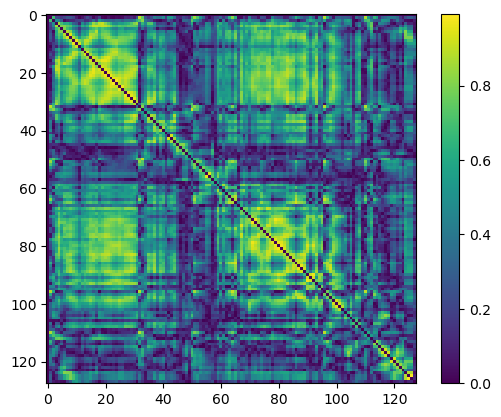

In [11]:
plt.imshow(A, interpolation='none')
plt.colorbar()

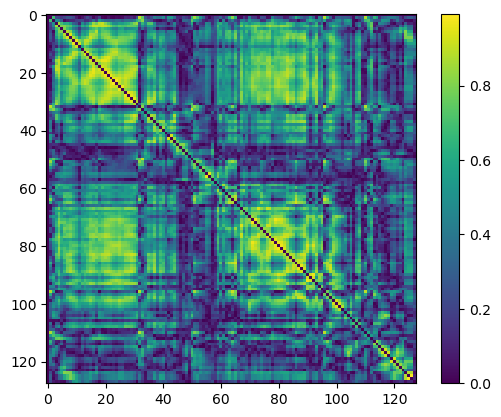

In [12]:
plt.imshow(A, interpolation='none')
plt.colorbar()

# Testing


In [13]:
import sys
sys.path.append('../')

In [14]:
from pathlib import Path
from utils import dataset
from scipy import stats

In [15]:
# Extract features

def extract_features(X, features):

    X_feat = [feat(X) for feat in features]
    X_feat = np.stack(X_feat, axis=-1)

    return X_feat 


def mean(X):
    return np.mean(X, axis=-1)

def std(X):
    return np.std(X, axis=-1)

def ptp(X):
    return np.ptp(X, axis=-1)

def var(X):
    return np.var(X, axis=-1)

def minim(X):
    return np.min(X, axis=-1)

def maxim(X):
    return np.max(X, axis=-1)

def argminim(X):
    return np.argmin(X, axis=-1)

def argmaxim(X):
    return np.argmax(X, axis=-1)

def rms(X):
    return np.sqrt(np.mean(X**2, axis=-1))

def abs_diff_signal(X):
    return np.sum(np.abs(np.diff(X, axis=-1)), axis=-1)

def skewness(X):
    return stats.skew(X, axis=-1)

def kurtosis(X):
    return stats.kurtosis(X, axis=-1)


In [16]:
from importlib import reload
reload(dataset)

root = Path('../EEGDataset/')
subjects = ['sub-01']
features = [mean, std, ptp, var, minim, maxim, argminim, argmaxim, rms, abs_diff_signal, skewness, kurtosis]
feat_transform = lambda var: extract_features(var, features)
graph_data = dataset.GraphDataset(root, subjects, feat_transform=None, reprocess=True, graph_type='corr_coef')

Processing...
Done!


In [17]:
graph_data[0]

Data(x=[128, 625], edge_index=[2, 16002], y=[1], edge_weights=[16002])

In [18]:
from torch_geometric.utils import to_dense_adj

In [23]:
import torch
A = to_dense_adj(graph_data[0].edge_index, edge_attr= graph_data[0].edge_weights)

In [28]:
graph_data[0].x

tensor([[ 2.8528e-07,  2.5948e-07,  5.1064e-07,  ...,  8.1850e-07,
          6.0102e-07,  5.8948e-07],
        [ 1.3961e-07, -8.5767e-08,  4.7438e-07,  ...,  1.0189e-06,
          6.3898e-07,  5.2778e-07],
        [-2.4653e-07,  5.5037e-08,  5.3521e-07,  ...,  5.0270e-07,
          1.4165e-07,  1.1246e-07],
        ...,
        [-6.0199e-07, -5.2198e-07, -3.8133e-07,  ..., -1.2143e-06,
         -8.5107e-07, -8.1572e-07],
        [-4.5384e-07, -5.3848e-07, -3.6864e-07,  ..., -1.1898e-06,
         -7.4384e-07, -8.3710e-07],
        [-9.5734e-07, -2.1923e-07,  1.9480e-07,  ..., -3.1582e-07,
         -5.2343e-07, -2.4476e-06]])

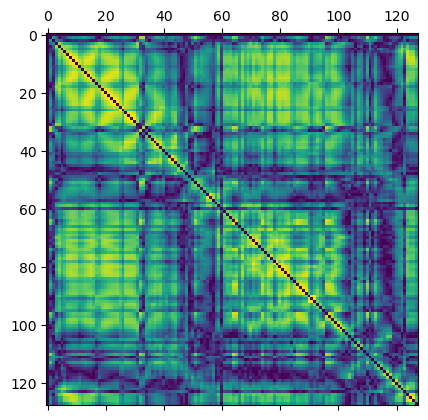

In [24]:
plt.matshow(np.squeeze(A))

In [29]:
A_s = compute_adj(graph_data[0].x, pearson_corr_coef)

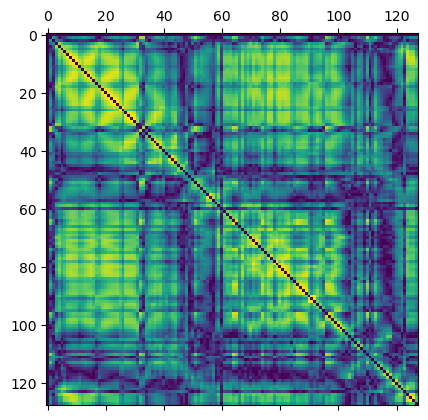

In [30]:
plt.matshow(A_s)

In [31]:
np.allclose(A,A_s)

True